<a href="https://colab.research.google.com/github/Horusprg/Project-1-Individual-ADL-2024.2/blob/main/Projeto_1_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Initial Procedure

In [ ]:
!git clone https://github.com/lasseufpa/tabular_rl.git

Cloning into 'tabular_rl'...
remote: Enumerating objects: 252, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 252 (delta 14), reused 14 (delta 8), pack-reused 228
Receiving objects: 100% (252/252), 148.04 KiB | 4.93 MiB/s, done.
Resolving deltas: 100% (154/154), done.


In [ ]:
%cd tabular_rl

/content/tabular_rl


In [ ]:
!pip install -e .
#!pip install gymnasium
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install tf-keras
!import sys
!sys.path.append('/content/tabular_rl/build/lib')
!pip install stable-baselines3

Obtaining file:///content/tabular_rl
  Preparing metadata (setup.py) ... done
  Running setup.py develop for tabular-rl
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [808 kB]
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRele

# Imports

In [ ]:
import numpy as np
import gym

#Tabular_RL GIT
from tabular_rl import simple_known_dynamics as skd
from tabular_rl import finite_mdp_utils as fmdp
from tabular_rl import known_dynamics_env as kde
from tabular_rl import optimum_values as optimum
from tabular_rl import verbose_kd_env as verbKd
from tabular_rl import sutton_grid_world as sgw

#Imports to TF agent
import stable_baselines3
from __future__ import absolute_import, division, print_function
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb
import tensorflow as tf
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

#Creating Custon Envs



In [ ]:
kd = kde.KnownDynamicsEnv

# Get the probabilities and rewards tables
nextStateProbability = np.array([
        [[0.2, 0.8, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]],
        [[0.1, 0.2, 0.7, 0, 0, 0], [0, 0.2, 0.8, 0, 0, 0]],
        [[0, 0, 0.05, 0.95, 0, 0], [0, 0.05, 0.1, 0.85, 0, 0]],
        [[0, 0, 0.1, 0.9, 0, 0], [0, 0, 0, 0.1, 0.9, 0]],
        [[0, 0.05, 0, 0, 0.75, 0.2], [0, 0, 0, 0, 0.1, 0.9]],
        [[1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]],
    ])
rewardsTable = np.array([[[0, 5, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]],
     [[-5, 0, 5, 0, 0, 0], [0, 0, 5, 0, 0, 0]],
     [[0, 0, 0, 5, 0, 0], [0, -5, 0, 5, 0, 0]],
     [[0, 0, -5, 0, 0, 0], [0, 0, 0, 0, 5, 0]],
     [[0, -10, 0, 0, 0, 50], [0, 0, 0, 0, 0, 50]],
     [[25, 0, 0, 0, 0, 0], [25, 0, 0, 0, 0, 0]]])


env = kd(nextStateProbability, rewardsTable) #creating the environment


#Getting the Sutton grid World Example
auxenv2 = sgw.SuttonGridWorldEnv
stateDictionaryGetIndex, stateListGivenIndex = auxenv2.createStatesDataStructures(_, 6)
nextStateProbability, rewardsTable = auxenv2.create_environment(_,6, stateDictionaryGetIndex)

env2 = kd(nextStateProbability, rewardsTable)


#Tabular

In [ ]:
import numpy as np

def value_iteration(env, gamma=0.99, epsilon=1e-6):
    state_values = np.zeros(env.S)  # Initialize state values
    policy = np.zeros(env.S, dtype=int)  # Initialize policy
    while True:
        delta = 0
        for s in range(env.S):
            q_values = np.zeros(env.A)
            for a in env.possible_actions_per_state[s]:  # Only iterate over valid actions for state s
                q_sa = 0
                for next_s in range(env.S):
                    p = env.nextStateProbability[s, a, next_s]
                    r = env.rewardsTable[s, a, next_s]
                    q_sa += p * (r + gamma * state_values[next_s])
                q_values[a] = q_sa
            max_q_value = np.max(q_values)
            delta = max(delta, abs(max_q_value - state_values[s]))
            state_values[s] = max_q_value
            policy[s] = np.argmax(q_values)
        if delta < epsilon:
            break

    return state_values, policy

# Usage example
state_values, policy = value_iteration(env)
print("Optimal state values:", state_values)
print("Optimal policy:", policy)

Optimal state values: [1381.22805673 1393.61730112 1406.16297536 1416.06369916 1426.90616602
 1392.41577617]
Optimal policy: [0 1 0 1 1 0]


In [ ]:
def describe_policy(policy, env):
    description = {}
    for state in range(env.S):
        action = policy[state]
        action_description = f"Action {action}"  # Replace this with meaningful descriptions if available
        description[f"State {state}"] = action_description
    return description

policy_description = describe_policy(policy, env)
print("Policy Description:")
for state_desc, action_desc in policy_description.items():
    print(f"In {state_desc}, the best action is {action_desc}.")

Policy Description:
In State 0, the best action is Action 0.
In State 1, the best action is Action 1.
In State 2, the best action is Action 0.
In State 3, the best action is Action 1.
In State 4, the best action is Action 1.
In State 5, the best action is Action 0.


## Q-Agent

In [ ]:
class QLearningAgent:
    def __init__(self, state_size, action_size, alpha, gamma, episodes, epsilon=0.1):
        self.state_size = state_size
        self.action_size = action_size
        self.alpha = alpha
        self.gamma = gamma
        self.episodes = episodes
        self.epsilon = epsilon
        self.q_table = np.zeros((env.observation_space.n, env.action_space.n))
        self.rewards_history = []

    def train(self, env):
        for episode in range(self.episodes):
            state = env.reset()
            total_reward = 0
            if isinstance(state, (list, np.ndarray)):
                state = state[0]  # Assumindo que o estado é sempre o primeiro elemento
            done = False
            while not done:
                action = self.choose_action(state, training=True)
                next_state, reward, done, _ = env.step(action)
                if isinstance(next_state, (list, np.ndarray)):
                    next_state = next_state[0]  # Assumindo que o estado é sempre o primeiro elemento
                print(f"Training: state={state}, action={action}, next_state={next_state}, reward={reward}")
                self.update_q_table(state, action, reward, next_state)
                state = next_state
                total_reward += reward
            self.rewards_history.append(total_reward)

    def update_q_table(self, state, action, reward, next_state):
        if isinstance(state, (list, np.ndarray)):
            state = state[0]
        if isinstance(next_state, (list, np.ndarray)):
            next_state = next_state[0]
        try:
            best_next_action = np.argmax(self.q_table[next_state])
            td_target = reward + self.gamma * self.q_table[next_state][best_next_action]
            td_error = td_target - self.q_table[state][action]
            self.q_table[state][action] += self.alpha * td_error
        except IndexError as e:
            print(f"IndexError: state={state}, action={action}, next_state={next_state}")
            raise e



    def choose_action(self, state, training=False):
        if isinstance(state, np.ndarray):
            state = state.item()  # Convertendo np.ndarray para um escalar inteiro se necessário
        valid_actions = env.possible_actions_per_state[state]
        if training and np.random.rand() < self.epsilon:
            return np.random.choice(valid_actions)  # Escolhe uma ação aleatória das válidas
        else:
            # Escolher a melhor ação válida baseada na tabela Q
            best_action = None
            best_value = -float('inf')
            for action in valid_actions:
                if self.q_table[state][action] > best_value:
                    best_value = self.q_table[state][action]
                    best_action = action
            return best_action



    def evaluate(self, env, episodes=100):
        total_rewards = []
        for _ in range(episodes):
            state = env.reset()
            done = False
            total_reward = 0
            while not done:
                action = self.choose_action(state)
                state, reward, done, _ = env.step(action)
                total_reward += reward
            total_rewards.append(total_reward)
        return np.mean(total_rewards), np.std(total_rewards)

In [ ]:
def setup_and_train_agents(env):
    hyperparameters = [
        (0.9, 0.1, 1000),
        (0.9, 0.1, 2000),
        (0.9, 0.2, 1000),
        (0.9, 0.2, 2000),
        (0.95, 0.1, 1000),
        (0.95, 0.1, 2000),
        (0.95, 0.2, 1000),
        (0.95, 0.2, 2000)
    ]
    agents = []
    for gamma, alpha, episodes in hyperparameters:
        agent = QLearningAgent(env.observation_space.n, env.action_space.n, alpha, gamma, episodes)
        agent.train(env)
        agents.append(agent)
    return agents

def plot_agents_performance(agents, env):
    results = [agent.evaluate(env) for agent in agents]
    means = [result[0] for result in results]
    stds = [result[1] for result in results]

    plt.errorbar(range(len(agents)), means, yerr=stds, fmt='-o')
    plt.xlabel('Agent Configuration')
    plt.ylabel('Average Reward')
    plt.title('Performance of Different Q-Learning Agents')
    plt.show()

def plot_convergence_by_gamma(agents):
    gammas = set(agent.gamma for agent in agents)  # Obter todos os valores únicos de gamma
    for gamma in gammas:
        plt.figure(figsize=(10, 6))
        for agent in agents:
            if agent.gamma == gamma:
                plt.plot(agent.rewards_history, label=f'Alpha: {agent.alpha}, Episodes: {agent.episodes}')
        plt.title(f'Convergência de Q-Learning com Gamma = {gamma}')
        plt.xlabel('Episódio')
        plt.ylabel('Recompensa Total')
        plt.legend()
        plt.show()

def plot_convergence_by_alpha(agents):
    alphas = set(agent.alpha for agent in agents)  # Obter todos os valores únicos de alpha
    for alpha in alphas:
        plt.figure(figsize=(10, 6))
        for agent in agents:
            if agent.alpha == alpha:
                plt.plot(agent.rewards_history, label=f'Gamma: {agent.gamma}, Episodes: {agent.episodes}')
        plt.title(f'Convergência de Q-Learning com Alpha = {alpha}')
        plt.xlabel('Episódio')
        plt.ylabel('Recompensa Total')
        plt.legend()
        plt.show()


A saída de streaming foi truncada nas últimas 5000 linhas.
Training: state=3, action=1, next_state=4, reward=5.0
Training: state=4, action=1, next_state=5, reward=50.0
Training: state=5, action=1, next_state=0, reward=25.0
Training: state=0, action=0, next_state=1, reward=5.0
Training: state=1, action=1, next_state=2, reward=5.0
Training: state=2, action=0, next_state=3, reward=5.0
Training: state=3, action=1, next_state=4, reward=5.0
Training: state=4, action=1, next_state=5, reward=50.0
Training: state=5, action=1, next_state=0, reward=25.0
Training: state=0, action=0, next_state=1, reward=5.0
Training: state=1, action=1, next_state=2, reward=5.0
Training: state=2, action=0, next_state=3, reward=5.0
Training: state=3, action=1, next_state=4, reward=5.0
Training: state=4, action=1, next_state=5, reward=50.0
Training: state=5, action=1, next_state=0, reward=25.0
Training: state=0, action=0, next_state=1, reward=5.0
Training: state=1, action=1, next_state=2, reward=5.0
Training: state=2

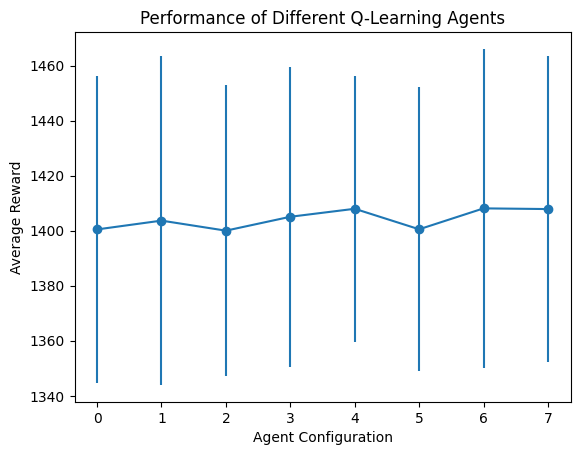

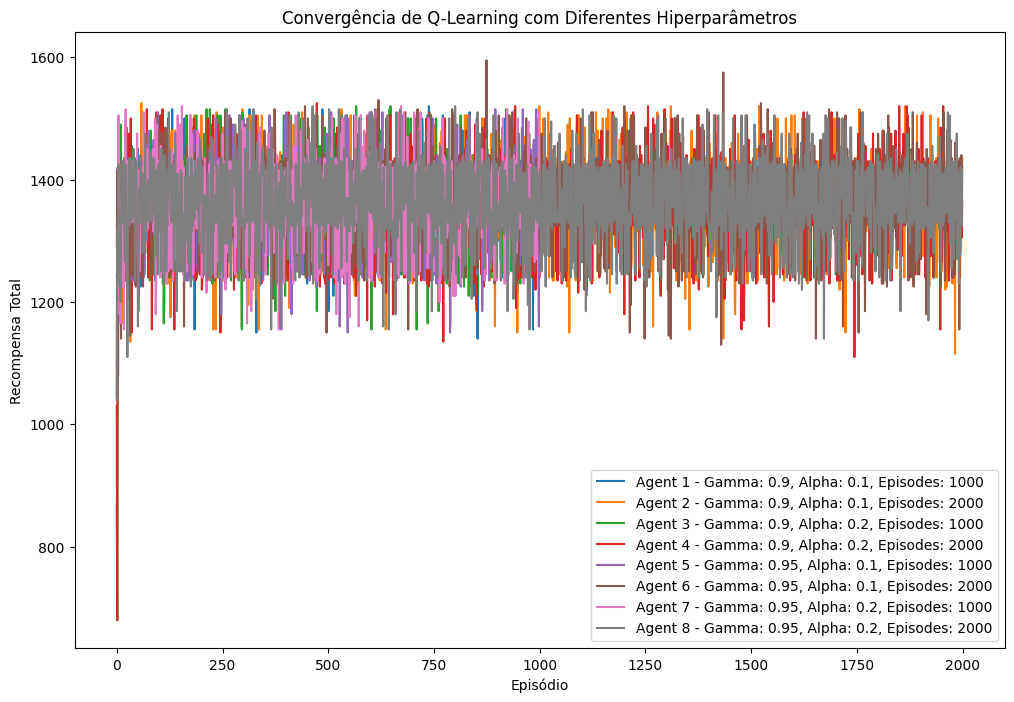

In [ ]:
kd = kde.KnownDynamicsEnv

# Get the probabilities and rewards tables
nextStateProbability = np.array([
        [[0.2, 0.8, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]],
        [[0.1, 0.2, 0.7, 0, 0, 0], [0, 0.2, 0.8, 0, 0, 0]],
        [[0, 0, 0.05, 0.95, 0, 0], [0, 0.05, 0.1, 0.85, 0, 0]],
        [[0, 0, 0.1, 0.9, 0, 0], [0, 0, 0, 0.1, 0.9, 0]],
        [[0, 0.05, 0, 0, 0.75, 0.2], [0, 0, 0, 0, 0.1, 0.9]],
        [[1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]],
    ])
rewardsTable = np.array([[[0, 5, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]],
     [[-5, 0, 5, 0, 0, 0], [0, 0, 5, 0, 0, 0]],
     [[0, 0, 0, 5, 0, 0], [0, -5, 0, 5, 0, 0]],
     [[0, 0, -5, 0, 0, 0], [0, 0, 0, 0, 5, 0]],
     [[0, -10, 0, 0, 0, 50], [0, 0, 0, 0, 0, 50]],
     [[25, 0, 0, 0, 0, 0], [25, 0, 0, 0, 0, 0]]])


env = kd(nextStateProbability, rewardsTable) #creating the environment

# Setup and train agents
agents = setup_and_train_agents(env)

# Avaliando e plotando o desempenho dos agentes
plot_agents_performance(agents, env)

[(1395.15, 55.23791723082976), (1393.55, 55.37280469689068), (1406.75, 55.13336104392693), (1409.2, 53.069388539910655), (1413.0, 52.091266062556016), (1408.7, 50.75243836506774), (1397.3, 54.46292316796812), (1402.1, 57.65492173266737)]


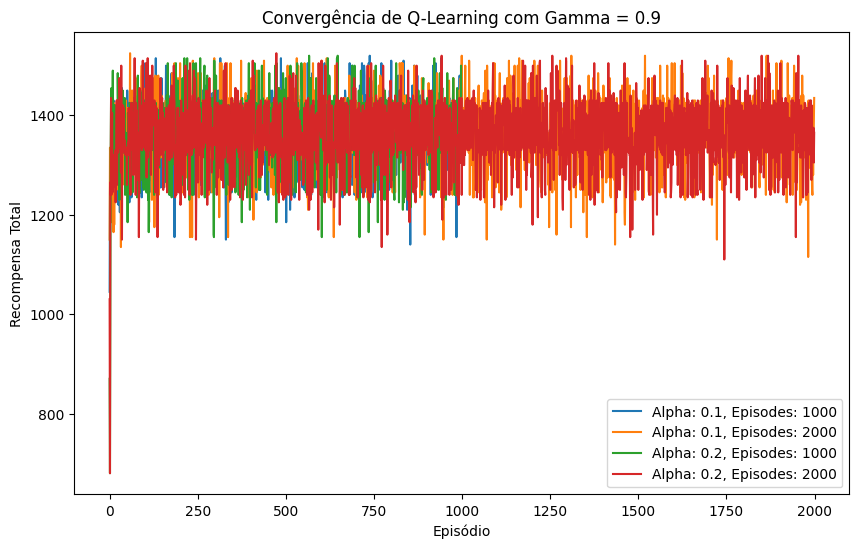

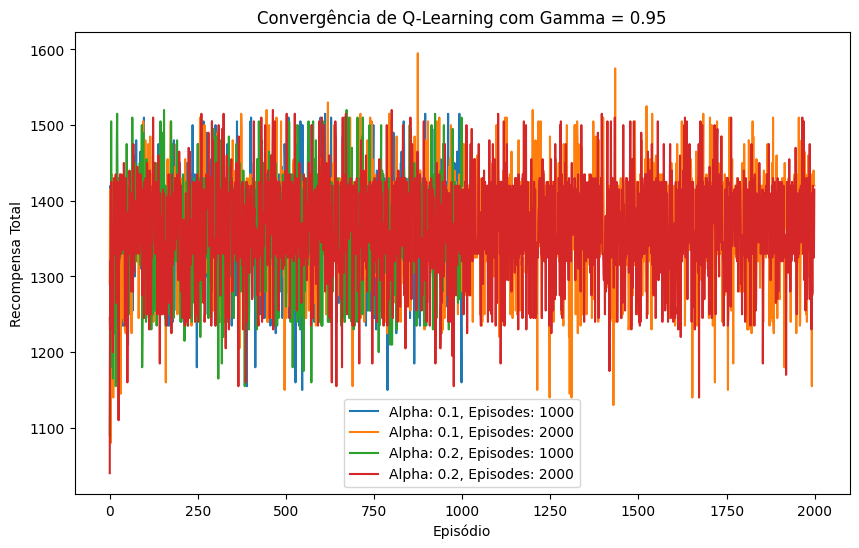

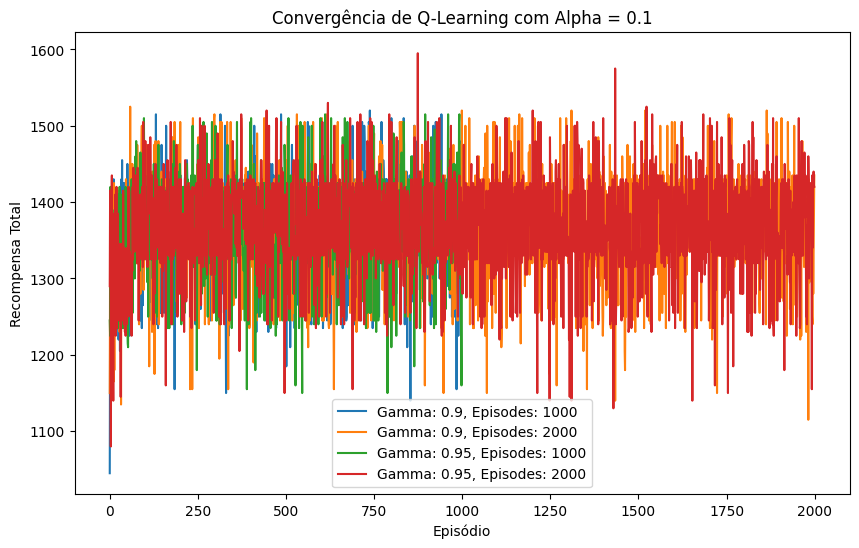

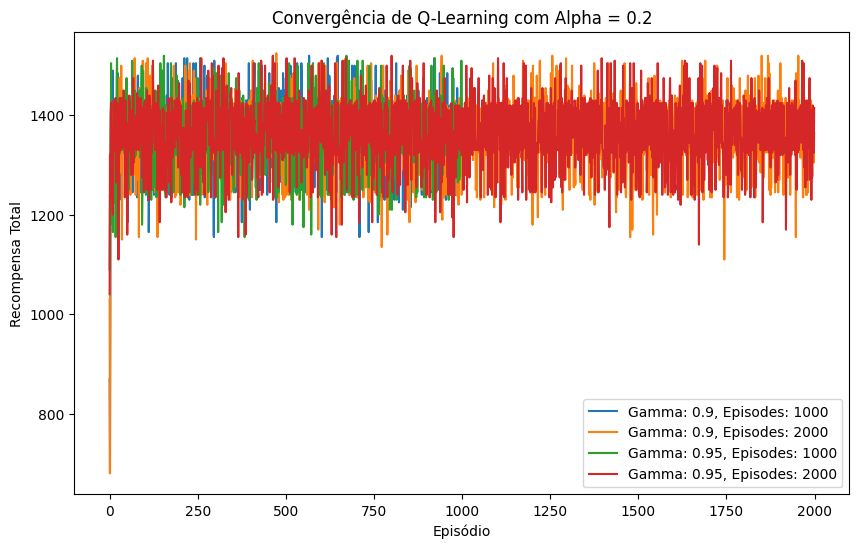

In [ ]:
results = [agent.evaluate(env) for agent in agents]
print(results)
plot_convergence_by_gamma(agents)
plot_convergence_by_alpha(agents)

#TF DQN Agent Topology 1

In [ ]:
env = suite_gym.wrap_env(env2)
train_env = tf_py_environment.TFPyEnvironment(env)
eval_env = tf_py_environment.TFPyEnvironment(env)

In [ ]:
#some Hyperparameter
num_iterations = 100000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration =   1# @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 15  # @param {type:"integer"}
eval_interval = 800  # @param {type:"integer"}

In [ ]:
#Topology of the net

fc_layer_params = (100, 75,50,25)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])



In [ ]:
q_net.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             multiple                  200       
                                                                 
 dense_10 (Dense)            multiple                  7575      
                                                                 
 dense_11 (Dense)            multiple                  3800      
                                                                 
 dense_12 (Dense)            multiple                  1275      
                                                                 
 dense_13 (Dense)            multiple                  104       
                                                                 
Total params: 12954 (50.60 KB)
Trainable params: 12954 (50.60 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()



In [ ]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

time_step = train_env.reset()

random_policy.action(time_step)



PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>, state=(), info=())

In [ ]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

In [ ]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)


In [ ]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

example_environment = tf_py_environment.TFPyEnvironment(env)


time_step = example_environment.reset()

avg_return = compute_avg_return(example_environment, random_policy, 5)

In [ ]:
train_py_env = env
eval_py_env = env

py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

(TimeStep(
 {'step_type': array(2, dtype=int32),
  'reward': array(0., dtype=float32),
  'discount': array(0., dtype=float32),
  'observation': array([18], dtype=int32)}),
 ())

In [ ]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset

iterator = iter(dataset)

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for _ in range(num_iterations):

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

step = 200: loss = 905463936.0
step = 400: loss = 1586755665920.0
step = 600: loss = 19952727752704.0
step = 800: loss = 96029244391424.0


KeyboardInterrupt: 

[-97.333336, -97.4, -96.73333, -97.666664, -96.6, -97.2, -97.333336, -97.26667, -97.73333, -97.666664, -96.933334, -97.86667, -96.86667, -97.86667, -97.0, -97.53333, -97.53333, -95.933334, -96.26667, -96.53333, -97.2, -98.333336, -97.26667, -97.46667, -96.8, -97.2, -98.066666, -97.4, -98.53333, -97.73333, -98.6, -97.8, -97.666664, -97.6, -97.86667, -97.333336, -97.73333, -94.73333, 1.0, -97.6, -95.333336, -96.8, -64.2, -96.73333, -95.8, -97.333336, -97.066666, -98.46667, -94.933334, -98.2, -97.666664, -97.13333, -96.933334, -98.2, -97.46667, -97.6, -97.26667, -96.73333, -97.4, -97.13333, -96.46667, -97.8, -97.6, -97.066666, -97.666664, -96.0, -97.066666, -96.933334, -96.933334, -96.86667, -97.26667, -98.2, -97.53333, -97.066666, -97.666664, -95.86667, -97.26667, -97.933334, -95.53333, -98.4, -96.0, -96.4, -96.73333, -97.26667, -97.066666, -97.4, -96.8, -96.4, -96.933334, -96.46667, -97.4, -97.86667, -96.8, -96.73333, -97.666664, -26.533333, 6.866667, 128.86667, -10.2, 124.933334, 42.53

Text(0.5, 0, 'Iterations')

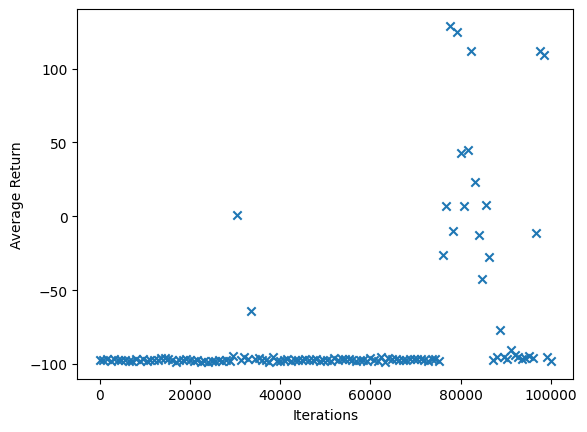

In [ ]:
print(returns)
iterations = range(0, num_iterations + 1, eval_interval)
plt.scatter(iterations, returns,marker = "x")
plt.ylabel('Average Return')
plt.xlabel('Iterations')


#TF DQN Agent Topology 2

In [ ]:
env = suite_gym.wrap_env(env2)
train_env = tf_py_environment.TFPyEnvironment(env)
eval_env = tf_py_environment.TFPyEnvironment(env)

In [ ]:
#some Hyperparameter
num_iterations = 100000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration =   1# @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 128  # @param {type:"integer"}
learning_rate = 1e-4  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 15  # @param {type:"integer"}
eval_interval = 800  # @param {type:"integer"}

In [ ]:
fc_layer_params = (100, 75, 50, 25)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation, kernel initializer, and regularizers.
def dense_layer(num_units):
    return tf.keras.layers.Dense(
        num_units,
        activation=tf.keras.activations.relu,
        kernel_initializer=tf.keras.initializers.VarianceScaling(
            scale=2.0, mode='fan_in', distribution='truncated_normal'),
        kernel_regularizer=tf.keras.regularizers.l2(0.01),  # L2 regularization
        bias_regularizer=tf.keras.regularizers.l2(0.01))    # L2 regularization

# Incorporating Batch Normalization and Dropout
def bn_and_dropout():
    return [
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.1)  # Adjust dropout rate as needed
    ]

# QNetwork consists of a sequence of Dense layers interspersed with Batch Normalization
# and Dropout, followed by a dense layer with `num_actions` units to generate one
# q_value per available action as its output.
layer_list = []
for num_units in fc_layer_params:
    layer_list.append(dense_layer(num_units))
    layer_list.extend(bn_and_dropout())  # Add BN and Dropout after each Dense layer

# Final Q values layer
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))

class PreprocessingLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        if len(inputs.shape) == 1:
            inputs = tf.expand_dims(inputs, axis=0)
        return inputs

dense_layers = [PreprocessingLayer()] + [dense_layer(num_units) for num_units in fc_layer_params]
q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [ ]:
q_net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocessing_layer (Prepr  multiple                  0         
 ocessingLayer)                                                  
                                                                 
 dense_5 (Dense)             multiple                  200       
                                                                 
 dense_6 (Dense)             multiple                  7575      
                                                                 
 dense_7 (Dense)             multiple                  3800      
                                                                 
 dense_8 (Dense)             multiple                  1275      
                                                                 
 dense_4 (Dense)             multiple                  104       
                                                        

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

In [ ]:
from tf_agents.trajectories import time_step as ts

random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())
time_step = train_env.reset()

action_step = random_policy.action(time_step)

In [ ]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)


random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

example_environment = tf_py_environment.TFPyEnvironment(env)

time_step = example_environment.reset()

avg_return = compute_avg_return(example_environment, random_policy, 5)

In [ ]:
train_py_env = env
eval_py_env = env

py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

(TimeStep(
 {'step_type': array(2, dtype=int32),
  'reward': array(-1., dtype=float32),
  'discount': array(0., dtype=float32),
  'observation': array([33], dtype=int32)}),
 ())

In [ ]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset

iterator = iter(dataset)

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for _ in range(num_iterations):

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


step = 200: loss = 8.73257827758789
step = 400: loss = 6.192093849182129
step = 600: loss = 6.229435920715332
step = 800: loss = 8.912811279296875
step = 800: Average Return = 65.19999694824219
step = 1000: loss = 8.929054260253906
step = 1200: loss = 8.277587890625
step = 1400: loss = 6.072150230407715
step = 1600: loss = 8.383284568786621
step = 1600: Average Return = 95.46666717529297
step = 1800: loss = 4.462852478027344
step = 2000: loss = 5.744494915008545
step = 2200: loss = 6.18162727355957
step = 2400: loss = 8.13479232788086
step = 2400: Average Return = -92.86666870117188
step = 2600: loss = 1170885.75
step = 2800: loss = 65230552.0
step = 3000: loss = 71744000.0
step = 3200: loss = 971467520.0
step = 3200: Average Return = -97.4000015258789
step = 3400: loss = 1018432192.0
step = 3600: loss = 1368081792.0
step = 3800: loss = 3264626688.0
step = 4000: loss = 1809020416.0
step = 4000: Average Return = -97.86666870117188
step = 4200: loss = 2957987840.0
step = 4400: loss = 130

[43.6, 65.2, 95.46667, -92.86667, -97.4, -97.86667, -97.333336, -96.066666, -95.666664, -97.333336, -97.6, -98.2, -97.6, -96.86667, -97.0, -96.933334, -97.6, -97.13333, -96.53333, -98.0, -97.333336, -98.0, -95.8, -97.86667, -96.933334, -97.26667, -97.26667, -97.0, -96.4, -97.86667, -97.933334, -97.666664, -95.8, -97.26667, -95.46667, -97.0, -55.466667, -64.13333, -76.26667, -77.73333, -37.933334, -43.733334, -84.46667, -57.066666, -96.2, -95.066666, -95.933334, -95.0, -96.6, -98.066666, -97.4, -98.333336, -98.066666, -96.53333, -97.13333, -97.4, -96.333336, -96.933334, -97.0, -98.333336, -96.46667, -97.13333, -97.53333, -97.6, -96.933334, -96.46667, -97.666664, -96.86667, -96.066666, -97.13333, -96.86667, -97.4, -96.666664, -97.86667, -97.4, -96.666664, -96.8, -97.2, -97.666664, -97.26667, -97.0, -96.86667, -98.066666, -96.86667, -97.333336, -97.666664, -97.13333, -96.86667, -95.8, -97.73333, -96.933334, -97.26667, -97.13333, -96.933334, -97.0, -97.46667, -97.2, -97.13333, -96.933334, 

Text(0.5, 0, 'Iterations')

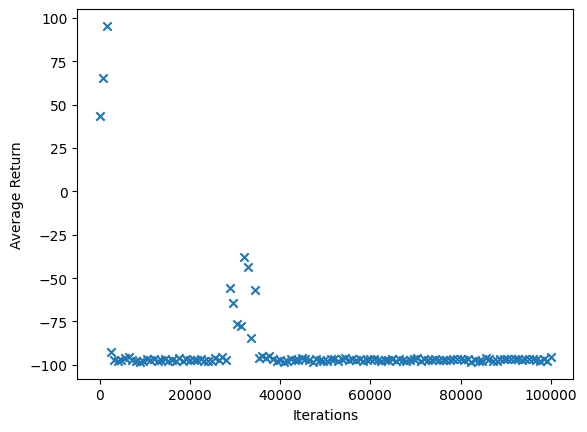

In [ ]:
print(returns)
iterations = range(0, num_iterations + 1, eval_interval)
plt.scatter(iterations, returns,marker = "x")
plt.ylabel('Average Return')
plt.xlabel('Iterations')
